In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
import numpy as np
import seaborn as sns
import datetime
import dateutil.relativedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
rosbank_train = pd.read_csv('rosbank_train.csv')
rosbank_train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
cl_ids_test = np.random.choice(rosbank_train.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [5]:
transactions_train = rosbank_train[~rosbank_train.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))

transactions_test = rosbank_train[rosbank_train.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  390343
Total transactions in test dataset:  100170


In [27]:
rosbank_train_x = rosbank_train[rosbank_train.target_flag == 1]
rosbank_train_x.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
109,01/06/2017,5,5944,NaN,810,18JUN17:00:00:00,3719.00,POS,1,326211.75
110,01/06/2017,5,6012,NaN,810,14JUN17:00:00:00,10000.00,C2C_OUT,1,326211.75
111,01/04/2017,5,5621,NaN,810,06APR17:00:00:00,1399.00,POS,1,326211.75
112,01/06/2017,5,5691,NaN,810,17JUN17:00:00:00,3190.00,POS,1,326211.75
113,01/04/2017,5,5499,NaN,810,25APR17:00:00:00,1387.61,POS,1,326211.75


In [28]:
rosbank_train['MCC'].value_counts().head(5)

5411    75343
6011    35524
5814    30285
5812    21741
5499    17913
Name: MCC, dtype: int64

Топ 5 самых популярных МСС:
    - Бакалейные магазины, супермаркеты (5411)
    - Финансовые учреждения – снятие наличности автоматически (6011)
    - Фастфуд (5814)
    - Места общественного питания, рестораны (5812)
    - Различные продовольственные магазины (5499)
Таким образом можно отметить, что самые популярные транзакции так, или  иначе связаны с питанием (покупка продуктов, 
заведения общественного питания), либо со снятием наличных в банкоматах.

In [34]:
rosbank_train['trx_category'].value_counts().head(5)

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
Name: trx_category, dtype: int64

Самый популярый способ оплаты - оплата бановской картой через POS-терминал

In [24]:
def transaction_by_day_count(rosbank_train):
    rosbank_train['day_of_transaction'] = rosbank_train['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = rosbank_train.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in rosbank_train['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
day_count = transaction_by_day_count(rosbank_train)
day_count.head()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [52]:
for column in day_count:
    print(day_count[column].sum())

25561672
62114.0
65927.0
68509.0
69485.0
71458.0
78993.0
74027.0


Чаще всего клиенты совершают покупки в конце недели и в выходные (наиболее популярный день - воскресенье), что не удивительно, 
ведь именнно в выходные семьи едут закупаться продуктами на предстоящую неделю

In [25]:
def transaction_by_hour_count(rosbank_train):
    rosbank_train['hour_of_transaction'] = rosbank_train['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return rosbank_train.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()
hour_count = transaction_by_hour_count(rosbank_train)
hour_count.head()

hour_of_transaction,cl_id,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
for column in hour_count:
    print(hour_count[column].sum())

25561672
432913.0
252.0
350.0
456.0
660.0
981.0
1315.0
1983.0
2699.0
3635.0
4088.0
4681.0
4707.0
4843.0
4397.0
4120.0
3848.0
3816.0
3659.0
2704.0
1797.0
1268.0
850.0
491.0


Наибольшее количество транзакций проходит с 10 до 14 (максимум - с 13 до 14). В рабочие дни в пикоыве часы как раз перерыв на обед, в выходные - люди выспались и идут за покупками.

Посмотрим распределние данных

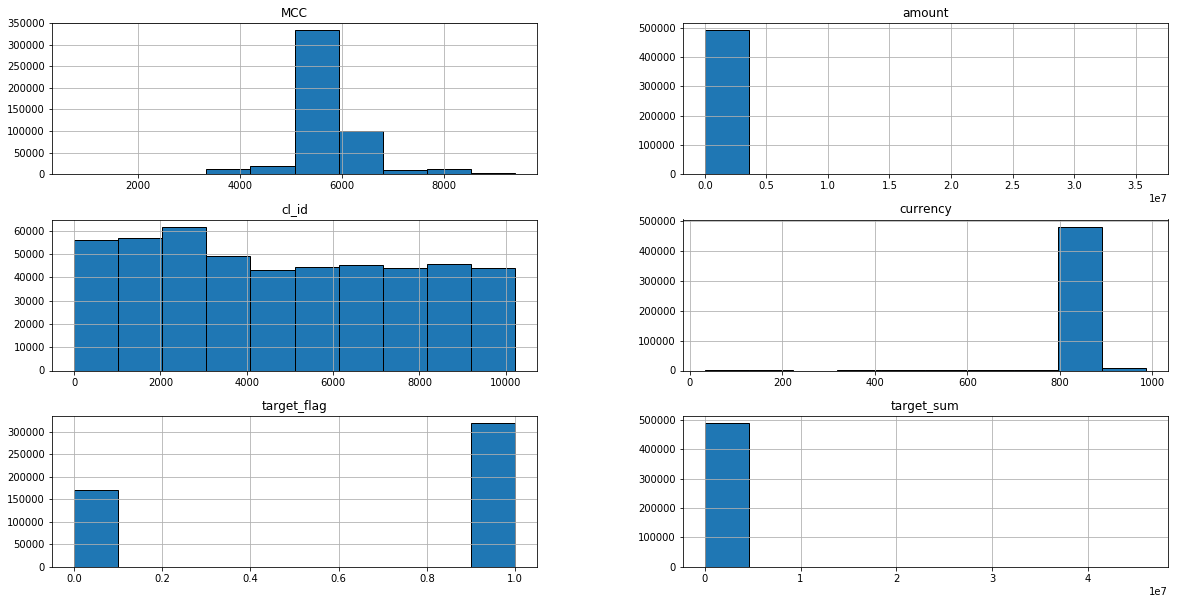

In [19]:
rosbank_train.hist(edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

Сумма и количество операций по каждому клиенту

In [38]:
train_group_trx = rosbank_train[
    ['cl_id', 'amount', 'trx_category']
].groupby(['cl_id', 'trx_category']).agg(['sum', 'count'])
train_group_trx.head()

amount      
                          sum count
cl_id trx_category                 
0     C2C_OUT        36562.00     1
      DEPOSIT        20000.00     1
      POS             7821.00     3
1     DEPOSIT        95000.00     2
      POS           122578.04   101

Сумма и количество использований денежных средств каждого клиента в рахных торговых точках

In [39]:
train_group_MCC = rosbank_train[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])
train_group_MCC.head()

amount      
                sum count
cl_id MCC                
0     5200   5023.0     1
      5411   2031.0     1
      5921    767.0     1
      6011  20000.0     1
      6012  36562.0     1

In [10]:
rosbank_train[rosbank_train.cl_id == 555].groupby(['PERIOD','trx_category']).count()

cl_id  MCC  channel_type  currency  TRDATETIME  \
PERIOD     trx_category                                                     
01/05/2017 CAT                 2    2             2         2           2   
           POS                 9    9             9         9           9   
           WD_ATM_OTHER        1    1             1         1           1   
           WD_ATM_PARTNER      1    1             1         1           1   
           WD_ATM_ROS          2    2             2         2           2   
01/06/2017 POS                72   72            72        72          72   
           WD_ATM_OTHER        3    3             3         3           3   
           WD_ATM_PARTNER      5    5             5         5           5   
01/07/2017 BACK_TRX            1    1             1         1           1   
           POS                56   56            56        56          56   
           WD_ATM_OTHER        2    2             2         2           2   
           WD_ATM_PARTNER      5    5             5         5           5   
           WD_ATM_ROS          2    2             2         2           2   
01/08/2017 POS                42   42            42        42          42   
           WD_ATM_OTHER        2    2             2         2           2   
           WD_ATM_PARTNER      1    1             1         1           1   
           WD_ATM_ROS          2    2             2         2           2   

                           amount  target_flag  target_sum  
PERIOD     trx_category                                     
01/05/2017 CAT                  2            2           2  
           POS                  9            9           9  
           WD_ATM_OTHER         1            1           1  
           WD_ATM_PARTNER       1            1           1  
           WD_ATM_ROS           2            2           2  
01/06/2017 POS                 72           72          72  
           WD_ATM_OTHER         3            3           3  
           WD_ATM_PARTNER       5            5           5  
01/07/2017 BACK_TRX             1            1           1  
           POS                 56           56          56  
           WD_ATM_OTHER         2            2           2  
           WD_ATM_PARTNER       5            5           5  
           WD_ATM_ROS           2            2           2  
01/08/2017 POS                 42           42          42  
           WD_ATM_OTHER         2            2           2  
           WD_ATM_PARTNER       1            1           1  
           WD_ATM_ROS           2            2           2

In [12]:
rosbank_train[(rosbank_train.cl_id == 555)&(rosbank_train.trx_category == 'POS')]

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
31310,01/06/2017,555,4121,type2,810,19JUN17:00:00:00,218.00,POS,1,214552.32
31312,01/06/2017,555,4121,type2,810,13JUN17:00:00:00,741.34,POS,1,214552.32
31313,01/05/2017,555,5691,type2,810,23MAY17:00:00:00,1498.00,POS,1,214552.32
31315,01/07/2017,555,4121,type2,810,07JUL17:00:00:00,84.00,POS,1,214552.32
31316,01/08/2017,555,7011,type2,810,11AUG17:00:00:00,58200.00,POS,1,214552.32
31318,01/07/2017,555,5411,type2,810,09JUL17:00:00:00,5969.00,POS,1,214552.32
31319,01/07/2017,555,5411,type2,810,19JUL17:00:00:00,152.00,POS,1,214552.32
31398,01/08/2017,555,5541,type2,810,04AUG17:00:00:00,658.40,POS,1,214552.32
31400,01/08/2017,555,5541,type2,810,04AUG17:00:00:00,1477.93,POS,1,214552.32
31401,01/07/2017,555,4121,type2,810,10JUL17:00:00:00,69.11,POS,1,214552.32


In [14]:
rosbank_train_grouped = rosbank_train[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])
rosbank_train_grouped.head()

amount      
                sum count
cl_id MCC                
0     5200   5023.0     1
      5411   2031.0     1
      5921    767.0     1
      6011  20000.0     1
      6012  36562.0     1

In [15]:
aggregated_dataset = rosbank_train_grouped.unstack()

In [16]:
def get_aggregated_rosbank_train(rosbank_train, agg_type, col_to_groupby):
    agg_rosbank_train = rosbank_train[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_rosbank_train = agg_rosbank_train.unstack(fill_value=0)
    agg_rosbank_train.columns = agg_rosbank_train.columns.get_level_values(2)

    old_name = agg_rosbank_train.columns.name
    old_cols = agg_rosbank_train.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_rosbank_train.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_rosbank_train

In [19]:
rosbank_train_mcc = pd.merge(
    get_aggregated_rosbank_train(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_rosbank_train(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

rosbank_train_trx_category = pd.merge(
    get_aggregated_rosbank_train(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_rosbank_train(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

rsb_train = pd.merge(
    rosbank_train_mcc,
    rosbank_train_trx_category,
    left_index=True,
    right_index=True,
)

In [20]:
rsb_train.head()

,MCC_mean_742,MCC_mean_763,MCC_mean_780,MCC_mean_1520,MCC_mean_1711,MCC_mean_1731,MCC_mean_1750,MCC_mean_1799,MCC_mean_2741,MCC_mean_2842,...,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [21]:
rsb_targets = rosbank_train[['cl_id', 'target_flag']].drop_duplicates().copy()
rsb_targets.index = rsb_targets['cl_id']
rsb_targets = rsb_targets.drop('cl_id', axis=1)
rsb_targets.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [22]:
rsb_train = pd.merge(
    rsb_train,
    rsb_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [24]:
rosbank_test_mcc = pd.merge(
    get_aggregated_rosbank_train(transactions_test, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_rosbank_train(transactions_test, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

rosbank_test_trx_category = pd.merge(
    get_aggregated_rosbank_train(transactions_test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_rosbank_train(transactions_test, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

rsb_test = pd.merge(
    rosbank_test_mcc,
    rosbank_test_trx_category,
    left_index=True,
    right_index=True,
)

In [25]:
rsb_test = pd.merge(
    rsb_test,
    rsb_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [26]:
X_test = rsb_test.drop(['target_flag'], axis=1)
y_test = rsb_test['target_flag']

In [27]:
X_train = rsb_train.drop(['target_flag'], axis=1)
y_train = rsb_train['target_flag']

In [29]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [30]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [31]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [32]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.8


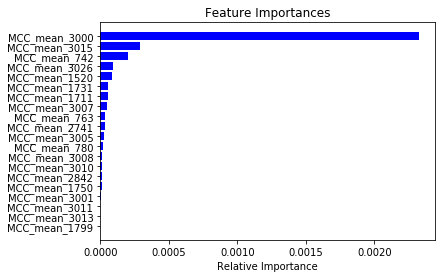

In [33]:
features = X_train.columns
importances = clf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()